In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

# 기본 테마로 설정
sns.set_theme()

In [2]:
# 데이터 경로
data_path = "data/"

# 데이터 불러오기 -> id는 index로 설정해준다.
train = pd.read_csv(data_path + 'train.csv', index_col='id') # 학습 데이터
test = pd.read_csv(data_path + 'test.csv', index_col='id') # 테스트 데이터
submission = pd.read_csv(data_path + 'sample_submission.csv') # 제출 양식

train.shape, test.shape

((6255, 12), (180, 11))

# 데이터 설명

- train.csv, test.csv : 학습 데이터, 테스트 데이터
    - id : 샘플 아이디
    - Store : 쇼핑몰 지점
    - Date : 주 단위(Weekly) 날짜
    - Temperature : 해당 쇼핑몰 주변 기온
    - Fuel_Price : 해당 쇼핑몰 주변 연료 가격
    - Promotion 1~5 : 해당 쇼핑몰의 비식별화된 프로모션 정보
    - Unemployment : 해당 쇼핑몰 지역의 실업률
    - IsHoliday : 해당 기간의 공휴일 포함 여부
    - **Weekly_Sales : 주간 매출액 (목표 예측값)**

- sample_submission.csv : 제출 양식
    - id : 샘플 아이디
    - **Weekly_Sales : 주간 매출액 (목표 예측값)**

In [3]:
# 학습 데이터 미리보기
train.head()

,Store,Date,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,Weekly_Sales
id,,,,,,,,,,,,
1,1,05/02/2010,42.31,2.572,NaN,NaN,NaN,NaN,NaN,8.106,False,1643690.90
2,1,12/02/2010,38.51,2.548,NaN,NaN,NaN,NaN,NaN,8.106,True,1641957.44
3,1,19/02/2010,39.93,2.514,NaN,NaN,NaN,NaN,NaN,8.106,False,1611968.17
4,1,26/02/2010,46.63,2.561,NaN,NaN,NaN,NaN,NaN,8.106,False,1409727.59
5,1,05/03/2010,46.50,2.625,NaN,NaN,NaN,NaN,NaN,8.106,False,1554806.68


In [4]:
# 테스트 데이터 미리보기
test.head()

,Store,Date,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday
id,,,,,,,,,,,
1,1,05/10/2012,68.55,3.617,8077.89,NaN,18.22,3617.43,3626.14,6.573,False
2,1,12/10/2012,62.99,3.601,2086.18,NaN,8.11,602.36,5926.45,6.573,False
3,1,19/10/2012,67.97,3.594,950.33,NaN,4.93,80.25,2312.85,6.573,False
4,1,26/10/2012,69.16,3.506,2585.85,31.75,6.00,1057.16,1305.01,6.573,False
5,2,05/10/2012,70.27,3.617,6037.76,NaN,10.04,3027.37,3853.40,6.170,False


In [5]:
# 제출 양식 미리보기
submission.head()

,id,Weekly_Sales
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


# 피처 해석하기

## 범주형 피처

- 명목형 피처 : Store, IsHoliday
    - 쇼핑몰 지점은 45개가 있음을 알 수 있다.
    - 테스트 데이터의 해당 기간의 공휴일 포함 여부는 없음만 있음을 알 수 있다. 또한, bool값으로 되어 있으니 인코딩이 필요함을 알 수 있다.
- 순서형 피처 : 없음

## 수치형 피처

- 이산형 피처 : 없음
- 연속형 피처 : Date, Temperature, Fuel_Price, Promotion 1~5, Unemployment, **Weekly_Sales**
    - 해당 쇼핑몰의 비식별화된 프로모션 정보는 결측치가 있음을 알 수 있다. 또한, 중복값이 몇 개 있음을 알 수 있다. 다른 쇼핑몰 지점이여도 존재하며, 같은 지점이어도 다른 날짜에 중복 사용을 한 것을 알 수 있다.
    - Date를 제외하고 정규분포형태가 아니기 때문에 변환하는 것이 더 좋을 것 같음을 알 수 있다.

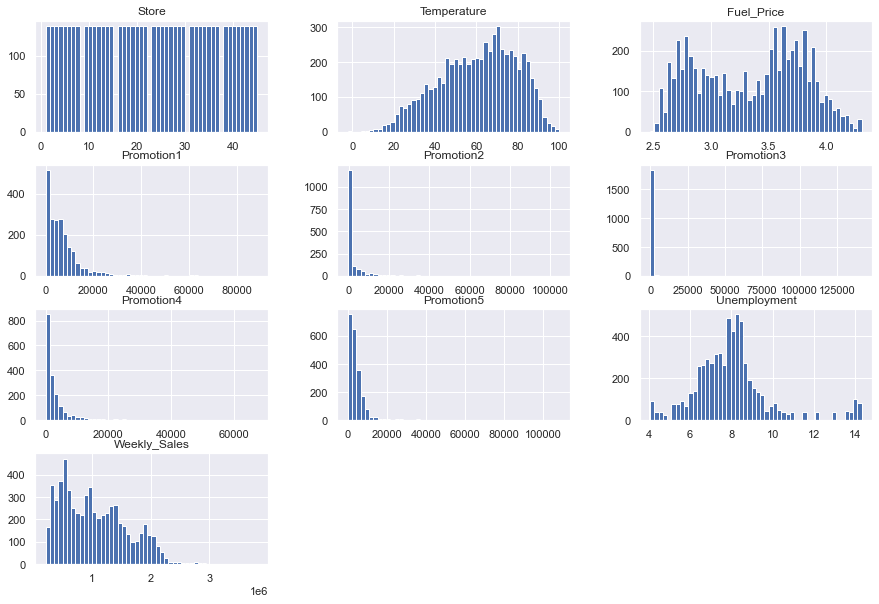

In [6]:
_ = train.hist(bins=50, figsize=(15, 10))

In [7]:
def resumetable(train, test):
    """피처 요약표 만들기"""
    print(f"== 학습 데이터 {train.shape}==")
    train_summary = pd.DataFrame(train.dtypes, columns=['데이터 타입'])\
                        .reset_index().rename(columns={'index' : '피처'})
    train_summary['결측값 개수'] = train.isnull().sum().values
    train_summary['고윳값 개수'] = train.nunique().values
    
    display(train_summary)
    
    print(f"== 테스트 데이터 {test.shape}==")
    test_summary = pd.DataFrame(test.dtypes, columns=['데이터 타입'])\
                        .reset_index().rename(columns={'index' : '피처'})
    test_summary['결측값 개수'] = test.isnull().sum().values
    test_summary['고윳값 개수'] = test.nunique().values
    
    display(test_summary)

In [8]:
resumetable(train, test)

== 학습 데이터 (6255, 12)==


,피처,데이터 타입,결측값 개수,고윳값 개수
0,Store,int64,0,45
1,Date,object,0,139
2,Temperature,float64,0,3470
3,Fuel_Price,float64,0,877
4,Promotion1,float64,4153,2099
5,Promotion2,float64,4663,1457
6,Promotion3,float64,4370,1562
7,Promotion4,float64,4436,1798
8,Promotion5,float64,4140,2114
9,Unemployment,float64,0,321


== 테스트 데이터 (180, 11)==


,피처,데이터 타입,결측값 개수,고윳값 개수
0,Store,int64,0,45
1,Date,object,0,4
2,Temperature,float64,0,136
3,Fuel_Price,float64,0,36
4,Promotion1,float64,2,178
5,Promotion2,float64,135,44
6,Promotion3,float64,19,146
7,Promotion4,float64,34,146
8,Promotion5,float64,0,180
9,Unemployment,float64,0,30


In [9]:
train['Promotion2'].value_counts()

1.50      9
0.50      9
1.91      8
3.00      7
4.00      6
         ..
7.27      1
193.94    1
191.82    1
54.94     1
20.64     1
Name: Promotion2, Length: 1457, dtype: int64

In [10]:
train.loc[train['Promotion2'] == 1.50]

,Store,Date,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,Weekly_Sales
id,,,,,,,,,,,,
1090,8,27/04/2012,70.34,3.814,5440.25,1.5,2.20,15.60,3302.44,5.679,False,879448.25
1368,10,27/04/2012,80.11,4.088,3444.43,1.5,3.39,124.18,2906.22,7.382,False,1712987.56
4554,33,10/02/2012,59.94,3.722,1437.28,1.5,4.94,NaN,1244.96,7.603,True,282552.58
4970,36,03/02/2012,61.33,3.421,1786.27,1.5,2.62,2.50,1373.38,7.244,False,310982.87
4975,36,09/03/2012,63.19,3.647,258.89,1.5,0.99,NaN,1835.63,7.244,False,318674.93
4976,36,16/03/2012,67.48,3.779,93.51,1.5,0.34,NaN,612.83,7.244,False,335345.82
5810,42,16/03/2012,62.11,4.273,438.48,1.5,2.35,NaN,2251.09,7.545,False,618767.26
5812,42,30/03/2012,67.92,4.294,341.00,1.5,NaN,21.94,1431.13,7.545,False,544408.14
6087,44,09/03/2012,38.24,3.380,2456.13,1.5,0.49,28.06,691.40,5.774,False,303438.24


### target 확인

- 정규 분포 형태가 아니어서 로그 변환 해준다.
- standard or robust는 변환되지 않아서 사용하지 않았다.

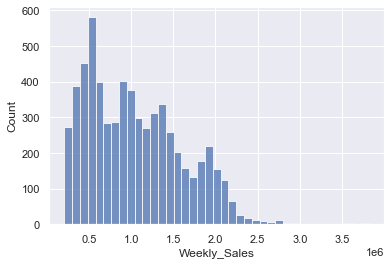

In [11]:
sns.histplot(data=train, x='Weekly_Sales')
plt.show()

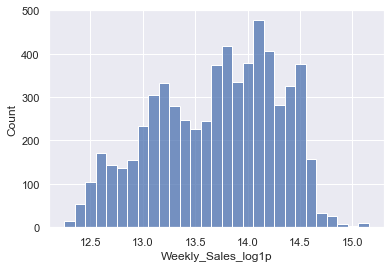

In [12]:
# 로그 변환
train['Weekly_Sales_log1p'] = np.log1p(train['Weekly_Sales'])

sns.histplot(data=train, x='Weekly_Sales_log1p')
plt.show()